In [12]:
import pandas as pd
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Database Configuration
DB_CONFIG = {
    'host': 'localhost',
    'database': 'SQLTEST',
    'user': 'postgres',
    'password': 'Admin'
}

# Step 1: Establish a database connection
connection = psycopg2.connect(**DB_CONFIG)


In [3]:

# Step 2: Define the SQL query
sql_query = """
WITH last_order_date AS (
    SELECT 
        MAX(created_at) AS max_date
    FROM 
        public.orders
)
SELECT 
    p.id AS product_id,
    pn.name AS product_name,
    c.name AS category_name,
    pvs.stock AS current_stock,
    pvp.price AS current_price,
    COALESCE(SUM(o.total_amount), 0) AS total_sales_last_week,
    COALESCE(AVG(pr.rating), 0) AS average_rating,
    COUNT(DISTINCT o.id) AS total_orders_last_week,
    (SELECT COUNT(*) 
     FROM public.orders o2 
     WHERE o2.created_at >= (SELECT max_date FROM last_order_date) - INTERVAL '30 days' 
     AND o2.id IN (SELECT pr2.order_id FROM public.product_ratings pr2 WHERE pr2.product_id = p.id)) AS total_orders_last_month,
    (SELECT COUNT(*) 
     FROM public.orders o3 
     WHERE o3.created_at >= (SELECT max_date FROM last_order_date) - INTERVAL '7 days' 
     AND o3.id IN (SELECT pr3.order_id FROM public.product_ratings pr3 WHERE pr3.product_id = p.id)) AS total_orders_last_7_days,
    pv.weight AS product_weight,
    pv.status AS variation_status,
    -- Assuming you have a way to identify if a product sold out in the next week
    CASE WHEN pvs.stock = 0 THEN 1 ELSE 0 END AS sold_out_next_week
FROM 
    public.products p
JOIN 
    public.product_names pn ON p.name_id = pn.id
JOIN 
    public.categories c ON pn.category_id = c.id
JOIN 
    public.product_variations pv ON p.id = pv.product_id
JOIN 
    public.product_variation_stocks pvs ON pv.id = pvs.product_variation_id
LEFT JOIN 
    public.product_variation_prices pvp ON pv.id = pvp.product_variation_id
LEFT JOIN 
    public.product_ratings pr ON pr.product_id = p.id
LEFT JOIN 
    public.orders o ON o.id = pr.order_id AND o.created_at >= (SELECT max_date FROM last_order_date) - INTERVAL '7 days'
GROUP BY 
    p.id, pn.name, c.name, pvs.stock, pvp.price, pv.weight, pv.status;
"""

In [4]:

# Step 3: Load dataset using the SQL query
data = pd.read_sql(sql_query, connection)


C:\Users\huawei\AppData\Local\Temp\ipykernel_3048\1710655366.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(sql_query, connection)


In [5]:
# Step 4: Prepare features and target
X = data[["current_stock", "current_price", "total_sales_last_week", "average_rating", "product_weight"]]
y = data["sold_out_next_week"]  # Binary target variable


In [16]:
# Step 5: Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# Step 6: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Step 7: Train the model with class weights
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [18]:
# Step 8: Make predictions
y_pred = model.predict(X_test_scaled)

In [19]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


In [20]:
# Step 9: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(classification_report(y_test, y_pred))

[[47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



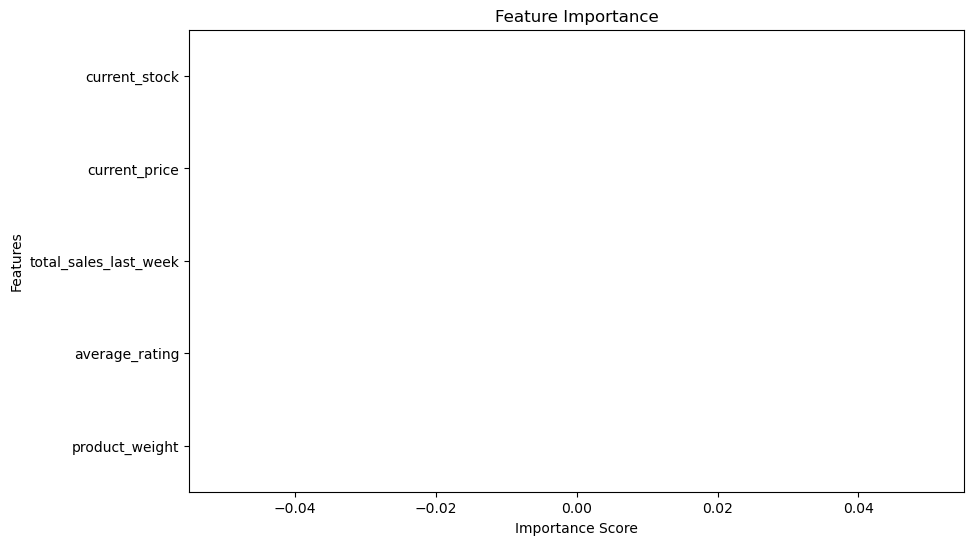

In [21]:
# Step 10: Feature Importance Plot
importance = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

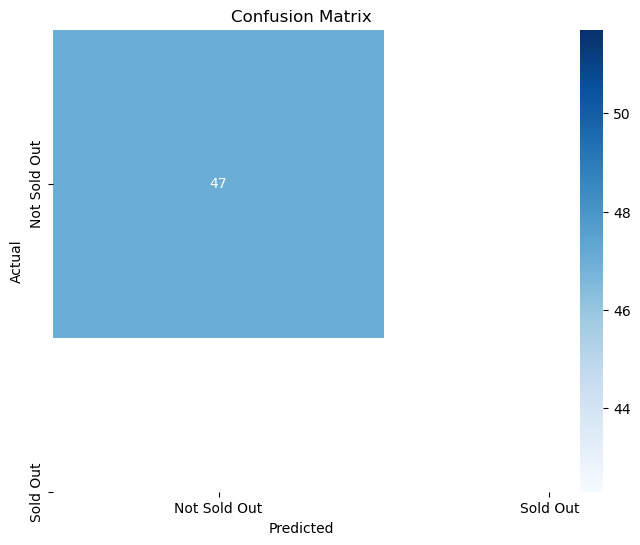

In [14]:

# Step 11: Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Sold Out', 'Sold Out'], 
            yticklabels=['Not Sold Out', 'Sold Out'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# Step 12: Distribution of Predicted Probabilities
y_prob = model.predict_proba(X_test_scaled)

# Check if the model predicts both classes
if y_prob.shape[1] > 1:
    # Only proceed if there are two classes
    y_prob = y_prob[:, 1]
    plt.figure(figsize=(10, 6))
    sns.histplot(y_prob, bins=30, kde=True)
    plt.title('Distribution of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Selling Out')
    plt.ylabel('Frequency')
    plt.axvline(x=0.5, color='red', linestyle='--')  # Threshold line
    plt.show()
else:
    print("Model predicts only one class; cannot plot predicted probabilities.")


Model predicts only one class; cannot plot predicted probabilities.


In [23]:
# Check the distribution of the target variable
print("Class Distribution:")
print(y.value_counts())

# Check for missing values in features
print("Missing Values in Features:")
print(X.isnull().sum())

# Check the number of unique values in each feature
print("Unique Values in Features:")
print(X.nunique())

# Check model predictions
print("Predictions Distribution:")
print(pd.Series(y_pred).value_counts())

Class Distribution:
sold_out_next_week
0    234
Name: count, dtype: int64
Missing Values in Features:
current_stock            0
current_price            0
total_sales_last_week    0
average_rating           0
product_weight           0
dtype: int64
Unique Values in Features:
current_stock            40
current_price            60
total_sales_last_week     2
average_rating            2
product_weight           15
dtype: int64
Predictions Distribution:
0    47
Name: count, dtype: int64


In [ ]:

# Step 10: Close the database connection
connection.close()